In [1]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
import urllib
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [3]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]
if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:30_000]
# You should also define a samller subset of the images for testing..
# TODO

# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on


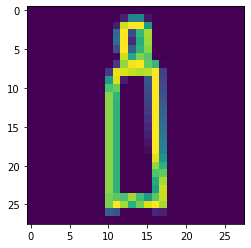

In [4]:
import matplotlib.pyplot as plt
plt.imshow(np.reshape(images[5], (28,28)))


In [5]:
import tensorflow as tf

### Preprocessing:

In [6]:
# from numpy to tf.Data.Dataset
dataset = tf.data.Dataset.from_tensor_slices(train_images)
# reshaping
dataset = dataset.map(lambda x: tf.reshape(x, (28, 28, 1)))
# normalize
dataset = dataset.map(lambda x: x/128-1)
# cache
dataset = dataset.cache()
# shuffling
dataset = dataset.shuffle(1000)
# batching
dataset = dataset.batch(32)
# prefetching
dataset = dataset.prefetch(100)

### Model:

In [7]:
class Discriminator(tf.keras.Model):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        self.layer_list = [
            layers.Conv2D(
                filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same',
                input_shape= [28, 28, 1]),
            layers.LeakyReLU(),
            layers.Dropout(rate= 0.3),

            layers.Conv2D(
                filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same'),
            layers.LeakyReLU(),
            layers.Dropout(rate= 0.3),

            layers.Flatten(),
            layers.Dense(1, activation = "sigmoid")
        ]
        """
        self.layer_list = [
            tf.keras.layers.Conv2D(filters=10, kernel_size=3),
            tf.keras.layers.Conv2D(filters=5, kernel_size=3),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]"""
    
    @tf.function(experimental_relax_shapes=True)
    def call(self, inputs) -> tf.Tensor:
        x = inputs
        for layer in self.layer_list:
            x = layer(x, training=True)
        return x

In [8]:
class Generator(tf.keras.Model):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.layer_list = [
            # sample latent space
            layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            # reshape from 1d to 2d
            layers.Reshape((7,7,256)),

            # create image
            layers.Conv2DTranspose(
                filters= 128, kernel_size=(3, 3), strides=(1, 1), padding='same', 
                use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(
                filters= 64, kernel_size=(3, 3), strides=(2, 2), padding='same', 
                use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),

            layers.Conv2DTranspose(
                filters= 1, kernel_size=(3, 3), strides=(2, 2), padding='same', 
                use_bias=False, activation='tanh')
        ]
        """
        self.layer_list = [
            tf.keras.layers.Dense(5),
            tf.keras.layers.Dense(49),
            tf.keras.layers.Reshape((7, 7, 1)),
            tf.keras.layers.Conv2DTranspose(8, 3, 2, padding='same'),
            tf.keras.layers.Conv2DTranspose(1, 3, 2, padding='same', activation='tanh')
        ]"""
    
    @tf.function(experimental_relax_shapes=True)
    def call(self, inputs) -> tf.Tensor:
        x = inputs
        for layer in self.layer_list:
            x = layer(x, training=True)
        return x

In [9]:
def generator_loss(fake_output, loss_function):
    return loss_function(tf.ones_like(fake_output), fake_output)

def discriminator_loss(fake_output, real_output, loss_function):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
@tf.function
def train_step(images, generator, discriminator, loss_function, optimizer_gen, optimizer_dis, noise_dim):
    N = tf.shape(images)[0]
    # generate fake data
    noise = tf.random.normal([N, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output, loss_function)
        disc_loss = discriminator_loss(real_output, fake_output, loss_function)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer_gen.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    optimizer_dis.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [11]:
def training(generator, discriminator, datasets, loss_function, optimizer_gen, optimizer_dis, noise_dim=100, epochs=5):
    gen_losses = []
    for e in range(epochs):
        print("Epoch:", e)
        for i, real_data in enumerate(datasets['train']):
            train_step(real_data, generator, discriminator, loss_function, optimizer_gen, optimizer_dis, noise_dim)
    return gen_losses
    


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


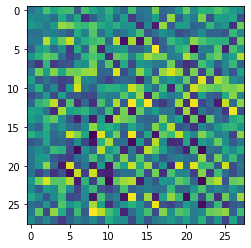

In [12]:
gen = Generator()
dis = Discriminator()
noise_dim = 100

example_img = gen(tf.random.normal((32, noise_dim)))[0].numpy()
plt.imshow(example_img[:,:,0])

gen_losses = training(
    gen, dis,
    {'train':dataset},
    tf.keras.losses.BinaryCrossentropy(from_logits=True),
    tf.keras.optimizers.Adam(0.001),
    tf.keras.optimizers.Adam(0.001),
    noise_dim=noise_dim)


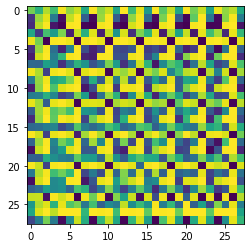

In [14]:
example_img = gen(tf.random.normal((32, 100)))[0].numpy()
plt.imshow(example_img[:,:,0])


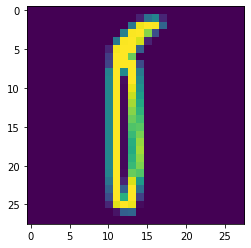

In [15]:
for img in dataset.take(1):
    plt.imshow(img[0][:,:,0])